# Emotion Detection in Written Sentences

## Dataset Preparation

Splitting the dataset into a 70/20/10 ratio for training, validation, and testing purposes

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('/kaggle/input/nlp-emotions/dataset.csv')

X = data['text']
y = data['emotion']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, stratify=y_train_val, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

## Exploratory Data Analysis (EDA)

Checking for null values and examining the balance of emotions in the dataset.

Number of Null Values in the Dataset:
text       0
emotion    0
dtype: int64
Number of Duplicates: 0
Distribution of Emotions in the Dataset:
joy         17528
sadness     17083
anger       16815
love        16790
fear        16343
surprise    15583
Name: emotion, dtype: int64


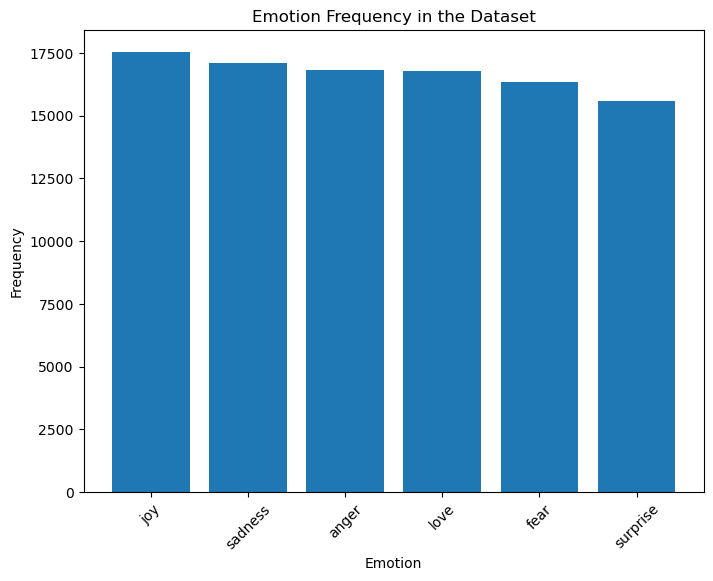

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = data

null_values = df.isnull().sum()
print("Number of Null Values in the Dataset:")
print(null_values)

duplicates_count = df.duplicated(subset='text').sum()
print("Number of Duplicates:", duplicates_count)

emotion_counts = df['emotion'].value_counts()
print("Distribution of Emotions in the Dataset:")
print(emotion_counts)

plt.figure(figsize=(8, 6))
plt.bar(emotion_counts.index, emotion_counts.values)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Frequency in the Dataset')
plt.xticks(rotation=45)
plt.show()

Conclusions:

- There are no null values or duplicates in the dataset, so it does not require handling of missing values.
- The dataset is well-balanced among the different emotional categories, allowing us to proceed with the data as it is, without the need for oversampling or undersampling techniques.

## Preprocessing and text normalization

In [8]:
import re
import emoji
import contractions
from joblib import Parallel, delayed
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    text = emoji.demojize(text)
    text = re.sub(r':[a-z_]+:', '', text) 
    text = re.sub(r'[^\w\s]', '', text)
    text = contractions.fix(text)

    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    normalized_text = ' '.join(tokens)
    
    return normalized_text

def normalize_batch(texts):
    return Parallel(n_jobs=-1)(delayed(normalize_text)(text) for text in texts)

train_df['text'] = normalize_batch(train_df['text'])
val_df['text'] = normalize_batch(val_df['text'])
test_df['text'] = normalize_batch(test_df['text'])

train_df.head()

,text,emotion
41184,feel sentimental attachment property,sadness
56077,hear buddy rage hard jaw lock,anger
17741,feel like offended someone,anger
73974,oh irony,surprise
36152,get many love feel stupid liking either,sadness


### Word Clouds

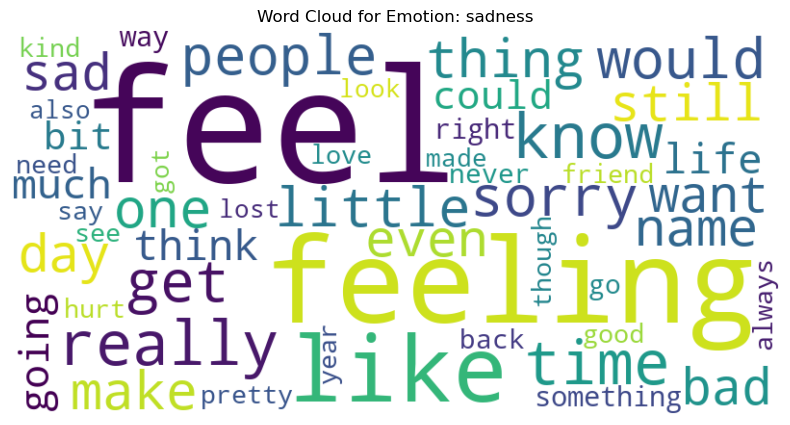

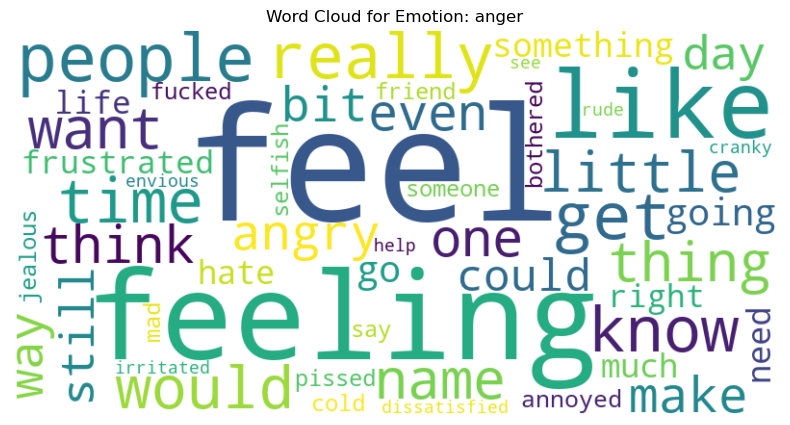

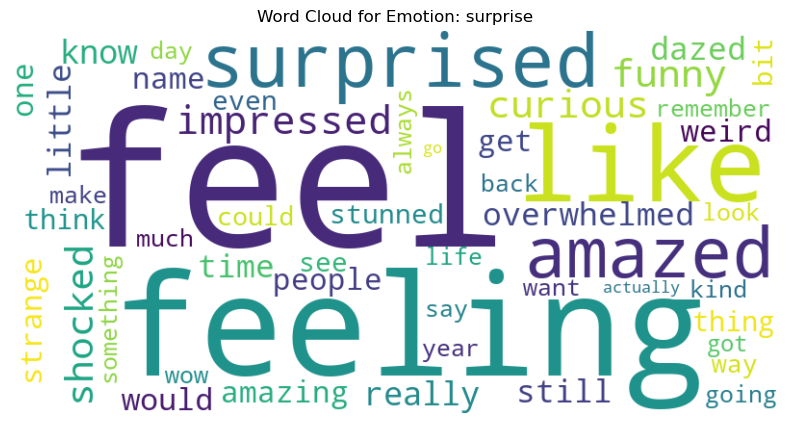

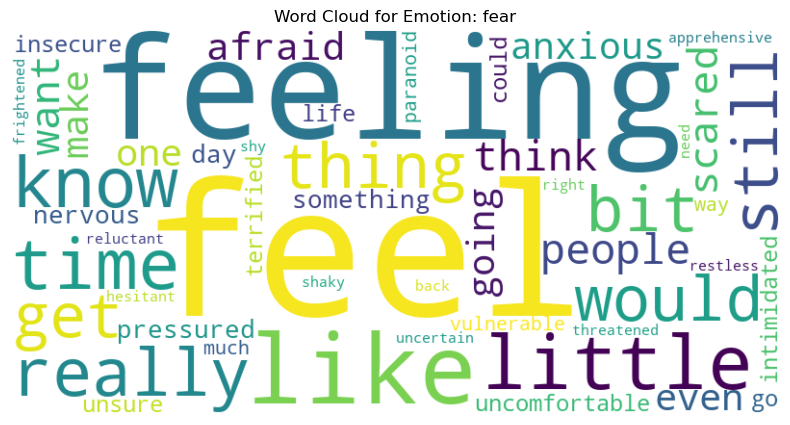

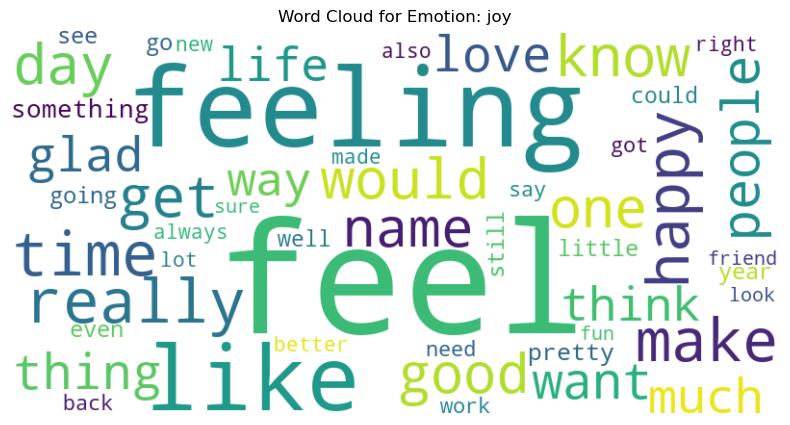

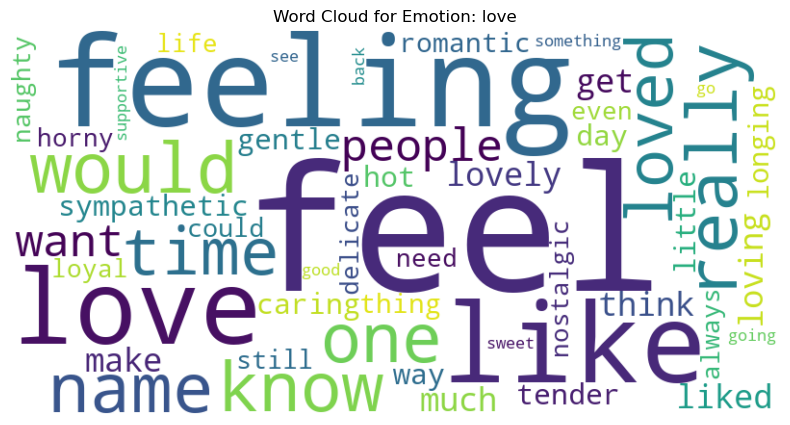

In [9]:
from wordcloud import WordCloud
from collections import Counter

emotion_categories = train_df['emotion'].unique()
for emotion in emotion_categories:
    sentences = train_df[train_df['emotion'] == emotion]['text']
    concatenated_sentences = ' '.join(sentences)
    
    tokens = word_tokenize(concatenated_sentences)
    word_counts = Counter(tokens)
    
    top_n = 50
    most_common_words = word_counts.most_common(top_n)
    top_words = [word for word, _ in most_common_words]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Emotion: {emotion}")
    plt.axis('off')
    plt.show()

## TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train = train_df['text']
y_train = train_df['emotion']

X_test = test_df['text']
y_test = test_df['emotion']

vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 3))
X_train_vectorized = vectorizer.fit_transform(X_train.values)
X_test_vectorized = vectorizer.transform(X_test.values)

## Naive Bayes

              precision    recall  f1-score   support

       anger       0.87      0.84      0.86      1682
        fear       0.89      0.86      0.87      1634
         joy       0.78      0.86      0.82      1753
        love       0.84      0.89      0.86      1679
     sadness       0.85      0.83      0.84      1709
    surprise       0.88      0.82      0.85      1558

    accuracy                           0.85     10015
   macro avg       0.85      0.85      0.85     10015
weighted avg       0.85      0.85      0.85     10015

Accuracy: 0.8498


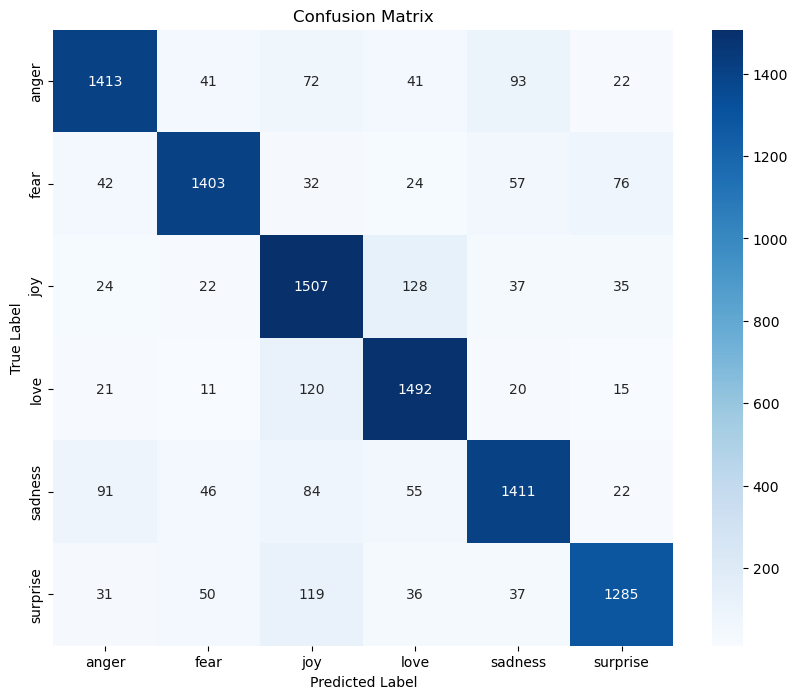

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

classifierNB = MultinomialNB()
classifierNB.fit(X_train_vectorized, y_train)

y_pred = classifierNB.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred) 
report = classification_report(y_test, y_pred)
print(report)
print(f"Accuracy: {accuracy:.4f}")

confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classifierNB.classes_, yticklabels=classifierNB.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Random Forest

              precision    recall  f1-score   support

       anger       0.86      0.88      0.87      1682
        fear       0.95      0.87      0.91      1634
         joy       0.83      0.87      0.85      1753
        love       0.90      0.92      0.91      1679
     sadness       0.88      0.85      0.87      1709
    surprise       0.88      0.89      0.89      1558

    accuracy                           0.88     10015
   macro avg       0.88      0.88      0.88     10015
weighted avg       0.88      0.88      0.88     10015

Accuracy: 0.8803


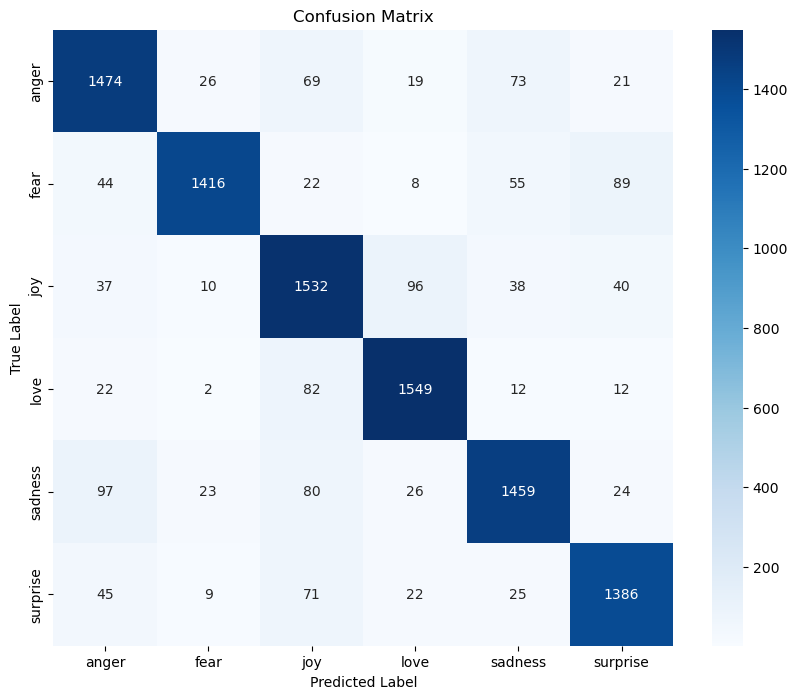

In [12]:
from sklearn.ensemble import RandomForestClassifier

X_train_vectorized = vectorizer.fit_transform(X_train.values)
X_test_vectorized = vectorizer.transform(X_test.values)

classifierRF = RandomForestClassifier(max_features="sqrt", min_samples_split=10, min_samples_leaf=2, n_jobs=-1)
classifierRF.fit(X_train_vectorized, y_train)

y_pred = classifierRF.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred) 
report = classification_report(y_test, y_pred)
print(report)
print(f"Accuracy: {accuracy:.4f}")

confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classifierRF.classes_, yticklabels=classifierRF.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## LSTM

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

GLOVE_PATH = '/kaggle/input/glove6b/glove.6B.100d.txt'

X_train = train_df['text'].values
y_train = train_df['emotion'].values

X_val = val_df['text'].values
y_val = val_df['emotion'].values

X_test = test_df['text'].values
y_test = test_df['emotion'].values

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_test = label_encoder.transform(y_test)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(sequence) for sequence in X_train)

X_train = pad_sequences(X_train, maxlen=max_length)
X_val = pad_sequences(X_val, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=128, recurrent_dropout=0.25, dropout=0.25,  return_sequences=True))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train, y_train, epochs=10, batch_size=128 ,validation_data=(X_val, y_val), callbacks=[early_stopping])

stopped_epoch = early_stopping.stopped_epoch
num_epochs = stopped_epoch + 1
loss, accuracy = model.evaluate(X_test, y_test)

print('Number of epochs:', num_epochs)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/10
550/550 [==============================] - 284s 505ms/step - loss: 0.8784 - accuracy: 0.6747 - val_loss: 0.3769 - val_accuracy: 0.8692
Epoch 2/10
550/550 [==============================] - 250s 454ms/step - loss: 0.3760 - accuracy: 0.8675 - val_loss: 0.3069 - val_accuracy: 0.8918
Epoch 3/10
550/550 [==============================] - 244s 444ms/step - loss: 0.3046 - accuracy: 0.8920 - val_loss: 0.2818 - val_accuracy: 0.9035
Epoch 4/10
550/550 [==============================] - 248s 450ms/step - loss: 0.2721 - accuracy: 0.9034 - val_loss: 0.2737 - val_accuracy: 0.9057
Epoch 5/10
550/550 [==============================] - 249s 452ms/step - loss: 0.2447 - accuracy: 0.9116 - val_loss: 0.2745 - val_accuracy: 0.9062
Epoch 6/10
550/550 [==============================] - 246s 447ms/step - loss: 0.2253 - accuracy: 0.9187 - val_loss: 0.2748 - val_accuracy: 0.9056
Epoch 7/10
313/313 [==============================] - 9s 28ms/step - loss: 0.2638 - accuracy: 0.9053
Number of epochs: 7
Tes

313/313 [==============================] - 8s 24ms/step
Best Epoch: 3
              precision    recall  f1-score   support

       anger       0.86      0.91      0.89      1682
        fear       0.93      0.91      0.92      1634
         joy       0.88      0.90      0.89      1753
        love       0.93      0.94      0.93      1679
     sadness       0.94      0.87      0.90      1709
    surprise       0.89      0.91      0.90      1558

    accuracy                           0.91     10015
   macro avg       0.91      0.91      0.91     10015
weighted avg       0.91      0.91      0.91     10015

Accuracy: 0.9053


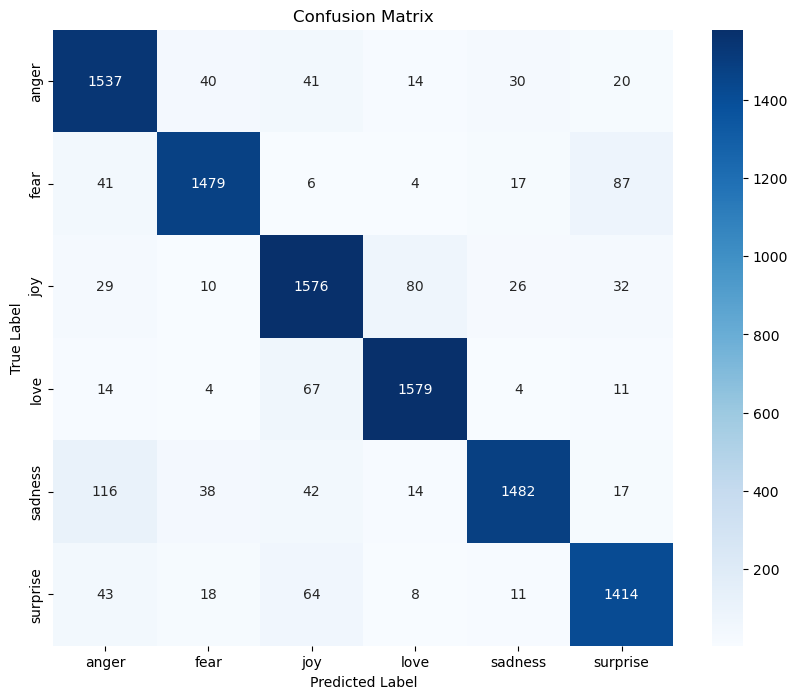

In [32]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

label_mapping = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}
y_pred_labels = [label_mapping[label] for label in y_pred]
y_test_labels = [label_mapping[label] for label in y_test]

best_epoch = early_stopping.best_epoch
print('Best Epoch:', best_epoch)

accuracy = accuracy_score(y_test_labels, y_pred_labels) 
report = classification_report(y_test_labels, y_pred_labels)
print(report)
print(f"Accuracy: {accuracy:.4f}")

confusion_mat = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Save trained models

In [30]:
import joblib

joblib.dump(classifierNB, '/kaggle/working/classifierNB.pkl')
joblib.dump(classifierRF, '/kaggle/working/classifierRF.pkl')
model.save('/kaggle/working/classifierLSTM.h5')